In [139]:
import h5py
with h5py.File('./statistics_cache/hydro_replace_Ml_1.00e12_Mu_3.16e12_R_0.5_z23_stats.h5', 'r') as f:
    print(f.keys())
    peaks = f['C_ell'][:]

<KeysViewHDF5 ['C_ell', 'LP_ids', 'ell', 'minima', 'peaks', 'run_ids', 'snr_bins']>


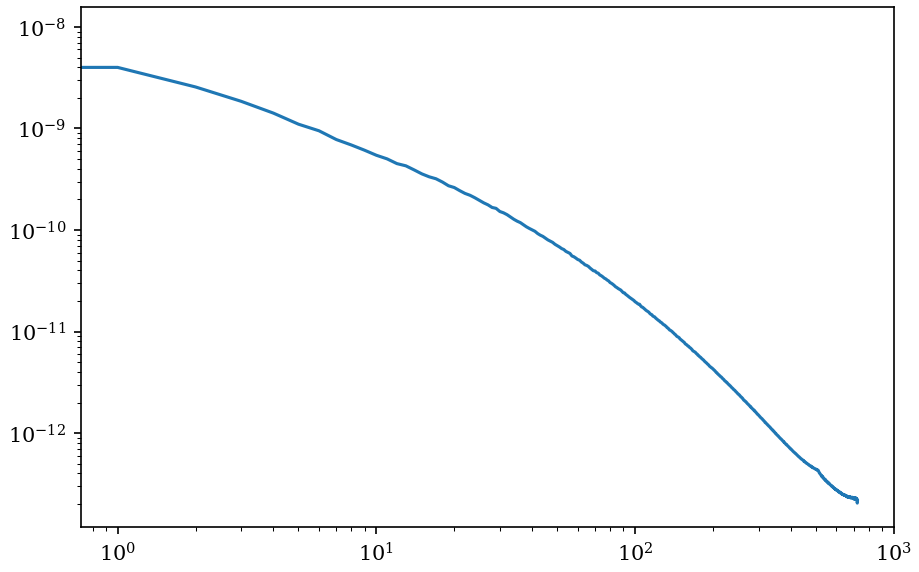

In [141]:
plt.loglog(peaks.mean(axis=0))

In [133]:
import numpy as np
import matplotlib.pyplot as plt
try:
    import Pk_library as PKL
    PYLIANS_AVAILABLE = True
    print("Pylians loaded successfully!")
except ImportError:
    PYLIANS_AVAILABLE = False
    print("Warning: Pylians not available. Install with: pip install Pylians")

from scipy import ndimage

import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

# Pylians for power spectrum computation
try:
    import Pk_library as PKL
    PYLIANS_AVAILABLE = True
    print("Pylians loaded successfully!")
except ImportError:
    PYLIANS_AVAILABLE = False
    print("Warning: Pylians not available. Install with: pip install Pylians")

# =============================================================================
# JOURNAL-READY PLOTTING CONFIGURATION
# =============================================================================
# Set up matplotlib for publication-quality figures

# Use TeX rendering for labels (comment out if LaTeX not available)
plt.rcParams['text.usetex'] = False  # Set to True if LaTeX is installed
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman', 'Times New Roman', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

# Figure sizes (single column ~3.5", double column ~7")
plt.rcParams['figure.figsize'] = (7, 4.5)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.05

# Font sizes (appropriate for journal figures)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['legend.title_fontsize'] = 10

# Line widths and marker sizes
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 5
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5

# Grid and legend
plt.rcParams['axes.grid'] = False
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.edgecolor'] = '0.8'

# Color scheme - use a colorblind-friendly palette
COLORS = {
    'dmo': '#000000',       # Black
    'hydro': '#0072B2',     # Blue
    'replace': '#009E73',   # Green
    'bcm': '#D55E00',       # Orange-red
    'error': '#CC79A7',     # Pink
}

# Mass bin colors (sequential viridis)
MASS_COLORS = plt.cm.viridis(np.linspace(0.15, 0.85, 4))

# Radius factor colors (sequential plasma)
RADIUS_COLORS = plt.cm.plasma(np.linspace(0.15, 0.85, 4))

# BCM model colors
BCM_COLORS = {
    'schneider19': '#E69F00',   # Orange
    'schneider25': '#56B4E9',   # Light blue
    'arico20': '#CC79A7',       # Pink
}

print("Journal-ready plotting configuration loaded!")

# =============================================================================
# Configuration - Paths matching the actual pipeline output structure
# =============================================================================

# Main lens plane output (from generate_all_unified.py)
LENSPLANE_BASE = Path('/mnt/home/mlee1/ceph/hydro_replace_LP/L205n2500TNG')

# Lux-format lens planes (from convert_to_lensplanes.py)  
LUX_LP_BASE = Path('/mnt/home/mlee1/ceph/hydro_replace_LP_lux/L205n2500TNG')

# Ray-tracing output (from lux)
RT_BASE = Path('/mnt/home/mlee1/ceph/hydro_replace_RT/L205n2500TNG')

# BCM lens planes (from generate_all_unified_bcm.py)
BCM_LP_BASE = Path('/mnt/home/mlee1/ceph/hydro_replace_LP_bcm/L205n2500TNG')

# Profile data (from generate_all_unified.py and generate_all_unified_bcm.py)
PROFILE_BASE = Path('/mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/profiles')
BCM_PROFILE_BASE = Path('/mnt/home/mlee1/ceph/hydro_replace_fields_bcm/L205n2500TNG/profiles')

# Simulation parameters
BOX_SIZE = 205.0  # Mpc/h
MASS_UNIT = 1e10  # Msun/h
GRID_RES = 4096   # Default lens plane grid resolution
RT_GRID = 1024    # Ray-tracing grid
N_REALIZATIONS = 10  # Number of LP realizations (LP_00 to LP_09)
N_RT_RUNS = 100   # Ray-tracing realizations per LP

# =============================================================================
# Mass bins - matching generate_all_unified.py naming convention
# Format: hydro_replace_Ml_{M_lo}_Mu_{M_hi}_R_{r_factor}
# =============================================================================

# Discrete mass bins (exclusive ranges) - DIFFERENTIAL in mass, CUMULATIVE in radius
# Each lensplane replaces halos in [M_lo, M_hi) within r < α × R_200
DISCRETE_MASS_BINS = [
    (1.00e12, 3.16e12, 'Ml_1.00e12_Mu_3.16e12'),   # 10^12.0 - 10^12.5
    (3.16e12, 1.00e13, 'Ml_3.16e12_Mu_1.00e13'),   # 10^12.5 - 10^13.0
    (1.00e13, 3.16e13, 'Ml_1.00e13_Mu_3.16e13'),   # 10^13.0 - 10^13.5
    (3.16e13, 1.00e15, 'Ml_3.16e13_Mu_1.00e15'),   # 10^13.5 - 10^15.0
]

# Cumulative mass bins (>= M_min) - CUMULATIVE in mass, CUMULATIVE in radius
# Each lensplane replaces halos with M >= M_min within r < α × R_200
CUMULATIVE_MASS_BINS = [
    (1.00e12, np.inf, 'Ml_1.00e12_Mu_inf'),  # 10^12.0+
    (3.16e12, np.inf, 'Ml_3.16e12_Mu_inf'),  # 10^12.5+
    (1.00e13, np.inf, 'Ml_1.00e13_Mu_inf'),  # 10^13.0+
    (3.16e13, np.inf, 'Ml_3.16e13_Mu_inf'),  # 10^13.5+
]

# Combined list
ALL_MASS_BINS = DISCRETE_MASS_BINS + CUMULATIVE_MASS_BINS

# Radius factors for Replace operator (α × R_200)
# Each Replace field is CUMULATIVE in radius: replaces within r < α × R_200
R_FACTORS = [0.5, 1.0, 3.0, 5.0]

# =============================================================================
# Snapshot configuration - 20 snapshots for ray-tracing
# =============================================================================
SNAPSHOT_ORDER = [96, 90, 85, 80, 76, 71, 67, 63, 59, 56, 52, 49, 46, 43, 41, 38, 35, 33, 31, 29]

# Accurate redshifts for TNG snapshots
SNAP_TO_Z = {
    99: 0.00, 96: 0.02, 90: 0.10, 85: 0.18, 80: 0.27, 76: 0.35,
    71: 0.46, 67: 0.55, 63: 0.65, 59: 0.76, 56: 0.85, 52: 0.97,
    49: 1.08, 46: 1.21, 43: 1.36, 41: 1.47, 38: 1.63, 35: 1.82,
    33: 1.97, 31: 2.14, 29: 2.32
}

# Stacking configuration (from lux): false = no stacking (z < 1), true = stack (z > 1)
SNAP_STACK = {snap: (SNAP_TO_Z[snap] > 0.9) for snap in SNAPSHOT_ORDER}

# =============================================================================
# Model list - all 34 models
# =============================================================================
def get_all_models():
    """Generate list of all model names matching pipeline output."""
    models = ['dmo', 'hydro']
    
    # All Replace configurations: 8 mass bins × 4 R factors = 32
    for mass_bin in ALL_MASS_BINS:
        for r_factor in R_FACTORS:
            model_name = f"hydro_replace_{mass_bin[2]}_R_{r_factor}"
            models.append(model_name)
    
    return models

SNR_BINS = np.linspace(-5, 10, 16)
SNR_MID = 0.5 * (SNR_BINS[:-1] + SNR_BINS[1:])

ALL_MODELS = get_all_models()
print(f"Total models: {len(ALL_MODELS)}")

# BCM models
BCM_MODELS = ['schneider19', 'schneider25', 'arico20']

print("Configuration loaded successfully!")
print(f"  Lensplane base: {LENSPLANE_BASE}")
print(f"  Profile base: {PROFILE_BASE}")
print(f"  BCM profile base: {BCM_PROFILE_BASE}")
print(f"  Snapshots: {len(SNAPSHOT_ORDER)} (z={SNAP_TO_Z[SNAPSHOT_ORDER[0]]:.2f} to z={SNAP_TO_Z[SNAPSHOT_ORDER[-1]]:.2f})")
print()
print("Replace Model Structure:")
print("  - DISCRETE mass bins: [M_lo, M_hi) at fixed α (4 bins × 4 α values)")
print("  - CUMULATIVE mass bins: M >= M_min at fixed α (4 thresholds × 4 α values)")
print("  - All models are CUMULATIVE in radius: replace within r < α × R_200")

cum_models = ['hydro_replace_Ml_1.00e12_Mu_inf_R_0.5',
'hydro_replace_Ml_1.00e12_Mu_inf_R_1.0',
'hydro_replace_Ml_1.00e12_Mu_inf_R_3.0',
'hydro_replace_Ml_1.00e12_Mu_inf_R_5.0',
'hydro_replace_Ml_3.16e12_Mu_inf_R_0.5',
'hydro_replace_Ml_3.16e12_Mu_inf_R_1.0',
'hydro_replace_Ml_3.16e12_Mu_inf_R_3.0',
'hydro_replace_Ml_3.16e12_Mu_inf_R_5.0',
'hydro_replace_Ml_1.00e13_Mu_inf_R_0.5',
'hydro_replace_Ml_1.00e13_Mu_inf_R_1.0',
'hydro_replace_Ml_1.00e13_Mu_inf_R_3.0',
'hydro_replace_Ml_1.00e13_Mu_inf_R_5.0',
'hydro_replace_Ml_3.16e13_Mu_inf_R_0.5',
'hydro_replace_Ml_3.16e13_Mu_inf_R_1.0',
'hydro_replace_Ml_3.16e13_Mu_inf_R_3.0',
'hydro_replace_Ml_3.16e13_Mu_inf_R_5.0']

diff_models = ['hydro_replace_Ml_1.00e12_Mu_3.16e12_R_0.5'
'hydro_replace_Ml_1.00e12_Mu_3.16e12_R_1.0',
'hydro_replace_Ml_1.00e12_Mu_3.16e12_R_3.0',
'hydro_replace_Ml_1.00e12_Mu_3.16e12_R_5.0',
'hydro_replace_Ml_1.00e13_Mu_3.16e13_R_0.5',
'hydro_replace_Ml_1.00e13_Mu_3.16e13_R_1.0',
'hydro_replace_Ml_1.00e13_Mu_3.16e13_R_3.0',
'hydro_replace_Ml_1.00e13_Mu_3.16e13_R_5.0',
'hydro_replace_Ml_3.16e12_Mu_1.00e13_R_0.5',
'hydro_replace_Ml_3.16e12_Mu_1.00e13_R_1.0',
'hydro_replace_Ml_3.16e12_Mu_1.00e13_R_3.0',
'hydro_replace_Ml_3.16e12_Mu_1.00e13_R_5.0',
'hydro_replace_Ml_3.16e13_Mu_1.00e15_R_0.5',
'hydro_replace_Ml_3.16e13_Mu_1.00e15_R_1.0',
'hydro_replace_Ml_3.16e13_Mu_1.00e15_R_3.0',
'hydro_replace_Ml_3.16e13_Mu_1.00e15_R_5.0',]

def compute_convergence_power_spectrum(kappa_maps, field_size_deg=5.0):
    """
    Compute convergence power spectrum C_ell from an ensemble of kappa maps using Pylians.
    
    Args:
        kappa_maps: Array of shape (n_maps, grid, grid)
        field_size_deg: Field size in degrees
    
    Returns:
        ell: Multipole values
        C_ell: Power spectrum (mean over realizations)
        C_ell_std: Standard deviation over realizations
    """
    n_maps, grid, _ = kappa_maps.shape
    field_size_rad = np.radians(field_size_deg)
    
    # Convert to effective "box size" for Pylians (in radians for angular Pk)
    box_size = field_size_rad
    
    C_ell_all = []
    ell = None
    
    for kappa in kappa_maps:
        # Subtract mean (compute fluctuation field)
        delta_kappa = (kappa - np.mean(kappa)).astype(np.float32)
        
        if PYLIANS_AVAILABLE:
            # Use Pylians for 2D power spectrum
            # k values from Pylians correspond to ell (in radians^-1)
            Pk2D = PKL.Pk_plane(delta_kappa, box_size, 'None', threads=4, verbose=False)
            ell = Pk2D.k   # In units of 1/radians (= multipole ell)
            C_ell = Pk2D.Pk  # Angular power spectrum
            C_ell_all.append(C_ell)
        else:
            # Fallback to numpy FFT
            kappa_k = np.fft.fft2(delta_kappa)
            Pk_2d = np.abs(kappa_k)**2 * (field_size_rad / grid)**2
            
            lx = np.fft.fftfreq(grid, d=field_size_rad/grid) * 2 * np.pi
            ly = np.fft.fftfreq(grid, d=field_size_rad/grid) * 2 * np.pi
            lx, ly = np.meshgrid(lx, ly)
            ell_2d = np.sqrt(lx**2 + ly**2)
            
            ell_bins = np.logspace(np.log10(100), np.log10(20000), 30)
            ell = 0.5 * (ell_bins[:-1] + ell_bins[1:])
            
            C_ell = np.zeros(len(ell))
            for i in range(len(ell)):
                mask = (ell_2d >= ell_bins[i]) & (ell_2d < ell_bins[i+1])
                if np.sum(mask) > 0:
                    C_ell[i] = np.mean(Pk_2d[mask])
            
            C_ell_all.append(C_ell)
    
    C_ell_all = np.array(C_ell_all)
    
    return ell, np.mean(C_ell_all, axis=0), np.std(C_ell_all, axis=0) / np.sqrt(n_maps)

def compute_power_spectrum_response(C_ell_models, ell):
    """
    Compute response fraction F_{C_ell} for all models.
    
    Args:
        C_ell_models: Dict {model_name: (C_ell, C_ell_err)}
        ell: Multipole array
    
    Returns:
        F_Cl: Dict {model_name: response_fraction}
    """
    C_D = C_ell_models['dmo'][0]
    C_H = C_ell_models['hydro'][0]
    Delta_C = C_H - C_D
    
    F_Cl = {}
    for model, (C_ell, _) in C_ell_models.items():
        if model not in ['dmo', 'hydro']:
            with np.errstate(divide='ignore', invalid='ignore'):
                F = np.where(np.abs(Delta_C) > 1e-30, (C_ell - C_D) / Delta_C, 0)
            F_Cl[model] = F
    
    return F_Cl

def smooth_map(kappa, smoothing_scale_pix):
    """Apply Gaussian smoothing to convergence map."""
    return ndimage.gaussian_filter(kappa, smoothing_scale_pix)

def find_peaks(kappa, snr_bins=SNR_BINS):
    """
    Find peaks in a convergence map and bin by SNR.
    
    Returns:
        peak_counts: Histogram of peak counts vs SNR
    """
    # Find local maxima (peaks)
    # A pixel is a peak if it's larger than all 8 neighbors
    data_max = ndimage.maximum_filter(kappa, size=3)
    peaks_mask = (kappa == data_max)
    
    # Remove edge effects
    peaks_mask[:2, :] = False
    peaks_mask[-2:, :] = False
    peaks_mask[:, :2] = False
    peaks_mask[:, -2:] = False
    
    # Get peak values in SNR units
    sigma = np.std(kappa)
    peak_values = kappa[peaks_mask] / sigma
    
    # Histogram
    peak_counts, _ = np.histogram(peak_values, bins=snr_bins)
    
    return peak_counts

def find_minima(kappa, snr_bins=SNR_BINS):
    """
    Find minima (troughs) in a convergence map and bin by SNR.
    
    Returns:
        minima_counts: Histogram of minima counts vs SNR
    """
    # Find local minima
    data_min = ndimage.minimum_filter(kappa, size=3)
    minima_mask = (kappa == data_min)
    
    # Remove edge effects
    minima_mask[:2, :] = False
    minima_mask[-2:, :] = False
    minima_mask[:, :2] = False
    minima_mask[:, -2:] = False
    
    # Get minima values in SNR units
    sigma = np.std(kappa)
    minima_values = kappa[minima_mask] / sigma
    
    # Histogram
    minima_counts, _ = np.histogram(minima_values, bins=snr_bins)
    
    return minima_counts

def compute_peak_counts_ensemble(kappa_maps, smoothing_pix=2.0, snr_bins=SNR_BINS):
    """Compute mean and std of peak counts over ensemble."""
    peaks_all = []
    minima_all = []
    
    for kappa in kappa_maps:
        kappa_smooth = smooth_map(kappa, smoothing_pix)
        peaks_all.append(find_peaks(kappa_smooth, snr_bins))
        minima_all.append(find_minima(kappa_smooth, snr_bins))
    
    peaks_all = np.array(peaks_all)
    minima_all = np.array(minima_all)
    
    return {
        'peaks_mean': np.mean(peaks_all, axis=0),
        'peaks_std': np.std(peaks_all, axis=0) / np.sqrt(len(kappa_maps)),
        'minima_mean': np.mean(minima_all, axis=0),
        'minima_std': np.std(minima_all, axis=0) / np.sqrt(len(kappa_maps)),
    }
def compute_peak_response(peak_results, snr_mid):
    """Compute response fraction for peak counts."""
    n_D_peaks = peak_results['dmo']['peaks_mean']
    n_H_peaks = peak_results['hydro']['peaks_mean']
    Delta_peaks = n_H_peaks - n_D_peaks
    
    n_D_min = peak_results['dmo']['minima_mean']
    n_H_min = peak_results['hydro']['minima_mean']
    Delta_min = n_H_min - n_D_min
    
    F_peaks = {}
    F_minima = {}
    
    for model in peak_results.keys():
        if model not in ['dmo', 'hydro']:
            n_R_peaks = peak_results[model]['peaks_mean']
            n_R_min = peak_results[model]['minima_mean']
            
            with np.errstate(divide='ignore', invalid='ignore'):
                F_peaks[model] = np.where(np.abs(Delta_peaks) > 0.01, 
                                         (n_R_peaks - n_D_peaks) / Delta_peaks, 1)
                F_minima[model] = np.where(np.abs(Delta_min) > 0.01,
                                          (n_R_min - n_D_min) / Delta_min, 1)
    
    return F_peaks, F_minima
print("Peak/minima detection functions defined.")

def load_kappa(fname, ng=1024):
    with open(fname, 'rb') as f:
        dummy = np.fromfile(f, dtype="int32", count=1)
        kappa = np.fromfile(f, dtype="float", count=ng*ng)
        dummy = np.fromfile(f, dtype="int32", count=1)
    return kappa.reshape(ng, ng)

def load_runs(base_path, model, z=23, LP_id=0, ng=1024):
    if z:
        kappas = np.zeros((50, ng, ng))
    else:
        kappas = np.zeros((50, 40, ng, ng))
        
    for i in range(1, 51):
        path = f'{base_path}/{model}/LP_{LP_id:02d}/run{i:03d}/'
        if z:
            zpath = path + f'kappa{z:02d}.dat'
            kappas[i-1] = load_kappa(zpath, ng=ng)
        else:
            for z in range(40):
                zpath =path + f'kappa{z:02d}.dat'
                kappas[i-1, z] = load_kappa(zpath, ng=ng)
                
    return kappas

def load_all_runs(base_path, model, z=23, ng=1024):
    kappas = np.zeros((10, 50, ng, ng))
    for LP in range(10):
        kappas[LP] = load_runs(base_path, model, z, LP_id=LP, ng=ng)
    return np.concatenate(kappas, axis=0)
base_path = '/mnt/home/mlee1/ceph/hydro_replace_RT/L205n2500TNG/'

for LP in range(10):
    r_factor = 5
    z=23
    c_ell_models = {}
    peak_results = {}
    for model in cum_models:
        try: 
            print(f'working on model {model}\n')
            maps = load_runs(base_path, model, z=z, LP_id=LP)
            ell, Cl_model, lstd_model = compute_convergence_power_spectrum(maps)
            c_ell_models[model] = (Cl_model, lstd_model)
            peak_results[model] = compute_peak_counts_ensemble(maps, smoothing_pix=7.0, snr_bins=SNR_BINS)
        except FileNotFoundError:
            print(model +' no good')
            
    dmo = load_runs(base_path, 'dmo', z=z, LP_id=LP)
    hydro = load_runs(base_path, 'hydro', z=z, LP_id=LP)
    ell, Cl_dmo, lstd_dmo = compute_convergence_power_spectrum(dmo)
    ell, Cl_hydro, lstd_hydro = compute_convergence_power_spectrum(hydro)
    c_ell_models['dmo'] = (Cl_dmo, lstd_dmo)
    c_ell_models['hydro'] = (Cl_hydro, lstd_hydro)
    peak_results['dmo'] = compute_peak_counts_ensemble(dmo, smoothing_pix=7.0, snr_bins=SNR_BINS)
    peak_results['hydro'] = compute_peak_counts_ensemble(hydro, smoothing_pix=7.0, snr_bins=SNR_BINS)
    
    F_cl = compute_power_spectrum_response(c_ell_models, ell)
    F_peak, F_minima = compute_peak_response(peak_results, SNR_MID)
    
    np.savez(f'./Fs/Fs_LP_{LP}', F_cl=F_cl, F_peak=F_peak, F_minima=F_minima)
      

Pylians loaded successfully!
Pylians loaded successfully!
Journal-ready plotting configuration loaded!
Total models: 34
Configuration loaded successfully!
  Lensplane base: /mnt/home/mlee1/ceph/hydro_replace_LP/L205n2500TNG
  Profile base: /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/profiles
  BCM profile base: /mnt/home/mlee1/ceph/hydro_replace_fields_bcm/L205n2500TNG/profiles
  Snapshots: 20 (z=0.02 to z=2.32)

Replace Model Structure:
  - DISCRETE mass bins: [M_lo, M_hi) at fixed α (4 bins × 4 α values)
  - CUMULATIVE mass bins: M >= M_min at fixed α (4 thresholds × 4 α values)
  - All models are CUMULATIVE in radius: replace within r < α × R_200
Peak/minima detection functions defined.
working on model hydro_replace_Ml_1.00e12_Mu_inf_R_0.5

working on model hydro_replace_Ml_1.00e12_Mu_inf_R_1.0

working on model hydro_replace_Ml_1.00e12_Mu_inf_R_3.0

working on model hydro_replace_Ml_1.00e12_Mu_inf_R_5.0

working on model hydro_replace_Ml_3.16e12_Mu_inf_R_0.5

working on

In [127]:
bad_ell = np.abs(Cl_hydro / Cl_dmo-1) < 0.01

In [128]:
r_factors = [0.5, 1.0, 3.0, 5.0]

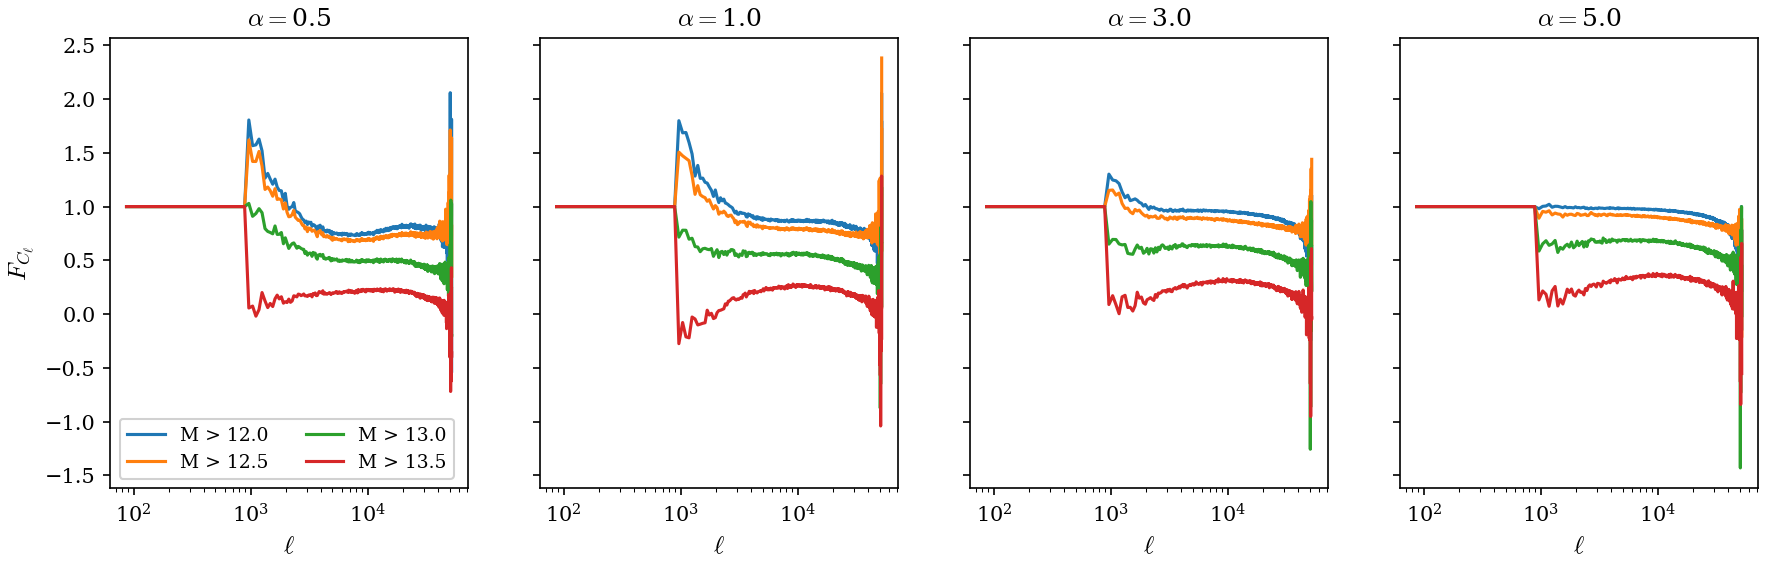

In [129]:
fig, axs = plt.subplots(ncols = 4, sharex=True, sharey=True, figsize=(12, 4))

for i in range(4):
    ax = axs[i]
    r_factor = r_factors[i]
    for j, model in enumerate(F_cl.keys()):
        if 'R_' + str(r_factor) in model:
            temp = F_cl[model]
            temp[bad_ell] = 1
            mass_thresh = np.round(np.log10(float(model.split('_')[3])), 2)
            alpha = float(model.split('_')[-1])
            ax.set_title(r'$\alpha=$' + str(alpha))
            ax.semilogx(ell, temp, label=f'M > {mass_thresh}')
# axs[0].set_ylim(-1, 2)
axs[0].legend(ncols=2)
for i in range(4):
    axs[i].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$F_{C_\ell}$')
plt.tight_layout()
plt.savefig('figures/F_cl.pdf')

In [130]:
SNR_MID

array([-4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,
        6.5,  7.5,  8.5,  9.5])

/tmp/ipykernel_394620/240455822.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(SNR_MID, peak_results['hydro']['peaks_mean'] / peak_results['dmo']['peaks_mean'])


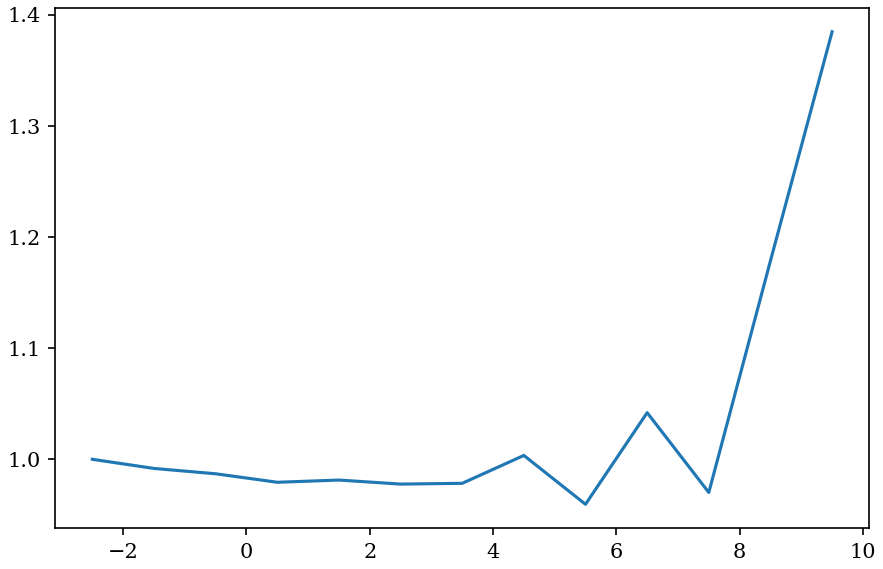

In [131]:
plt.plot(SNR_MID, peak_results['hydro']['peaks_mean'] / peak_results['dmo']['peaks_mean']) 

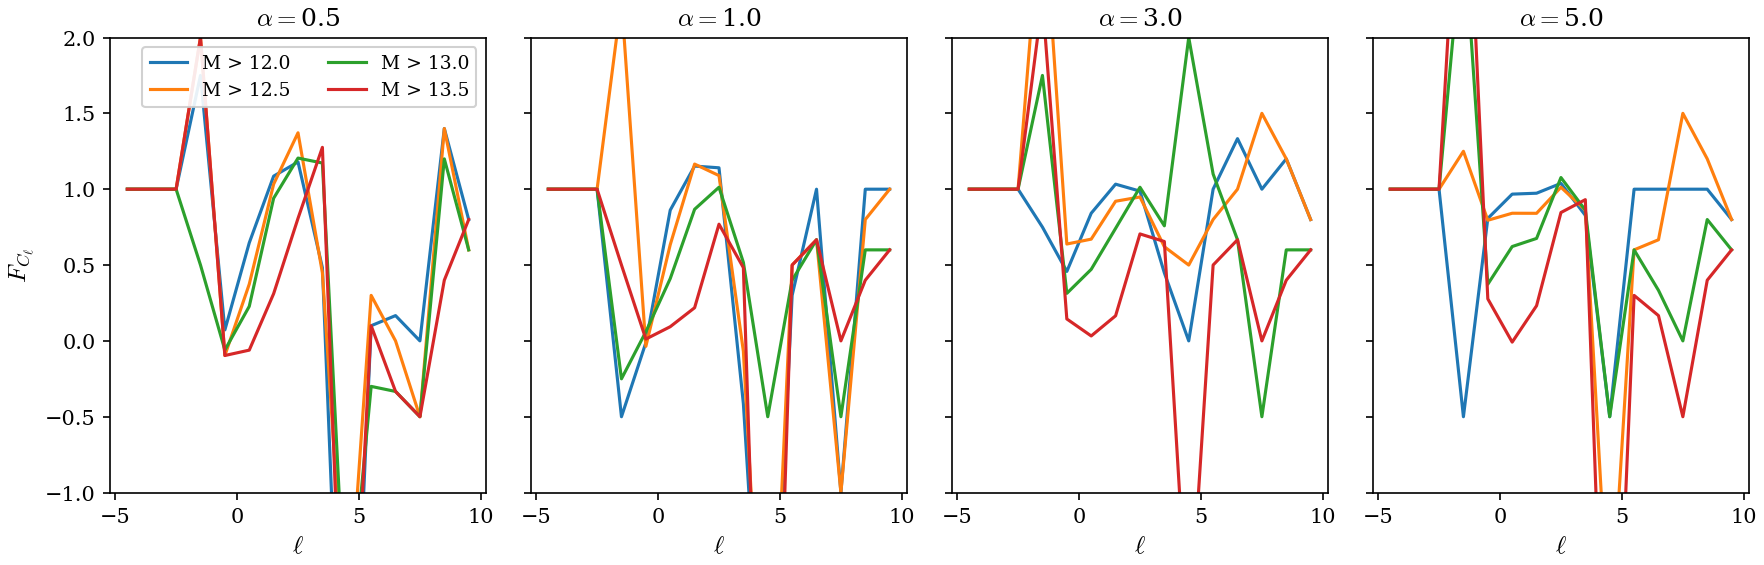

In [132]:
fig, axs = plt.subplots(ncols = 4, sharex=True, sharey=True, figsize=(12, 4))

for i in range(4):
    ax = axs[i]
    r_factor = r_factors[i]
    for j, model in enumerate(F_peak.keys()):
        if 'R_' + str(r_factor) in model:
            temp = F_peak[model]
            mass_thresh = np.round(np.log10(float(model.split('_')[3])), 2)
            alpha = float(model.split('_')[-1])
            ax.set_title(r'$\alpha=$' + str(alpha))
            ax.plot(SNR_MID, temp, label=f'M > {mass_thresh}')
axs[0].set_ylim(-1, 2)
axs[0].legend(ncols=2)
for i in range(4):
    axs[i].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$F_{C_\ell}$')
plt.tight_layout()
plt.savefig('figures/F_peak.pdf')

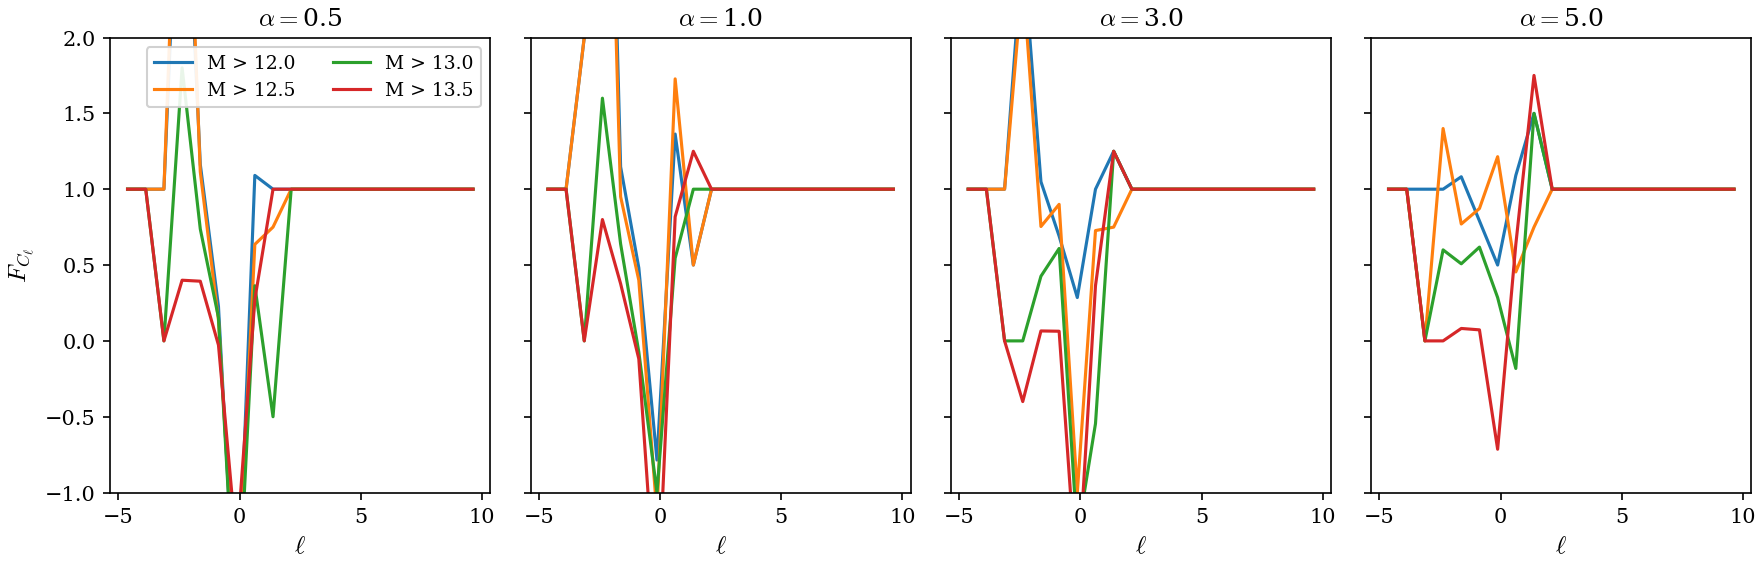

In [125]:
fig, axs = plt.subplots(ncols = 4, sharex=True, sharey=True, figsize=(12, 4))

for i in range(4):
    ax = axs[i]
    r_factor = r_factors[i]
    for j, model in enumerate(F_minima.keys()):
        if 'R_' + str(r_factor) in model:
            temp = F_minima[model]
            mass_thresh = np.round(np.log10(float(model.split('_')[3])), 2)
            alpha = float(model.split('_')[-1])
            ax.set_title(r'$\alpha=$' + str(alpha))
            ax.plot(SNR_MID, temp, label=f'M > {mass_thresh}')
axs[0].set_ylim(-1, 2)
axs[0].legend(ncols=2)
for i in range(4):
    axs[i].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$F_{C_\ell}$')
plt.tight_layout()
plt.savefig('figures/F_minima.pdf')

In [26]:
test = np.load(Fs[0], allow_pickle=True)['F_cl']
test.item().keys()

dict_keys(['hydro_replace_Ml_1.00e12_Mu_inf_R_0.5', 'hydro_replace_Ml_1.00e12_Mu_inf_R_1.0', 'hydro_replace_Ml_1.00e12_Mu_inf_R_3.0', 'hydro_replace_Ml_1.00e12_Mu_inf_R_5.0', 'hydro_replace_Ml_3.16e12_Mu_inf_R_0.5', 'hydro_replace_Ml_3.16e12_Mu_inf_R_1.0', 'hydro_replace_Ml_3.16e12_Mu_inf_R_3.0', 'hydro_replace_Ml_3.16e12_Mu_inf_R_5.0', 'hydro_replace_Ml_1.00e13_Mu_inf_R_0.5', 'hydro_replace_Ml_1.00e13_Mu_inf_R_1.0', 'hydro_replace_Ml_1.00e13_Mu_inf_R_3.0', 'hydro_replace_Ml_1.00e13_Mu_inf_R_5.0', 'hydro_replace_Ml_3.16e13_Mu_inf_R_0.5', 'hydro_replace_Ml_3.16e13_Mu_inf_R_1.0', 'hydro_replace_Ml_3.16e13_Mu_inf_R_3.0', 'hydro_replace_Ml_3.16e13_Mu_inf_R_5.0'])

In [99]:
import glob
Fs = sorted(glob.glob('./Fs/*'))
keys = np.load(Fs[0], allow_pickle=True)['F_cl'].item().keys()
super_dict_cl = {k:[] for k in keys}
for F in Fs:
    Fi = np.load(F, allow_pickle=True)
    for k, v in super_dict_cl.items():
        try:
            v.append(Fi['F_cl'].item()[k])
        except:
            pass
super_dict_cl = {k:np.mean(v, axis=0) for k, v in super_dict_cl.items()}

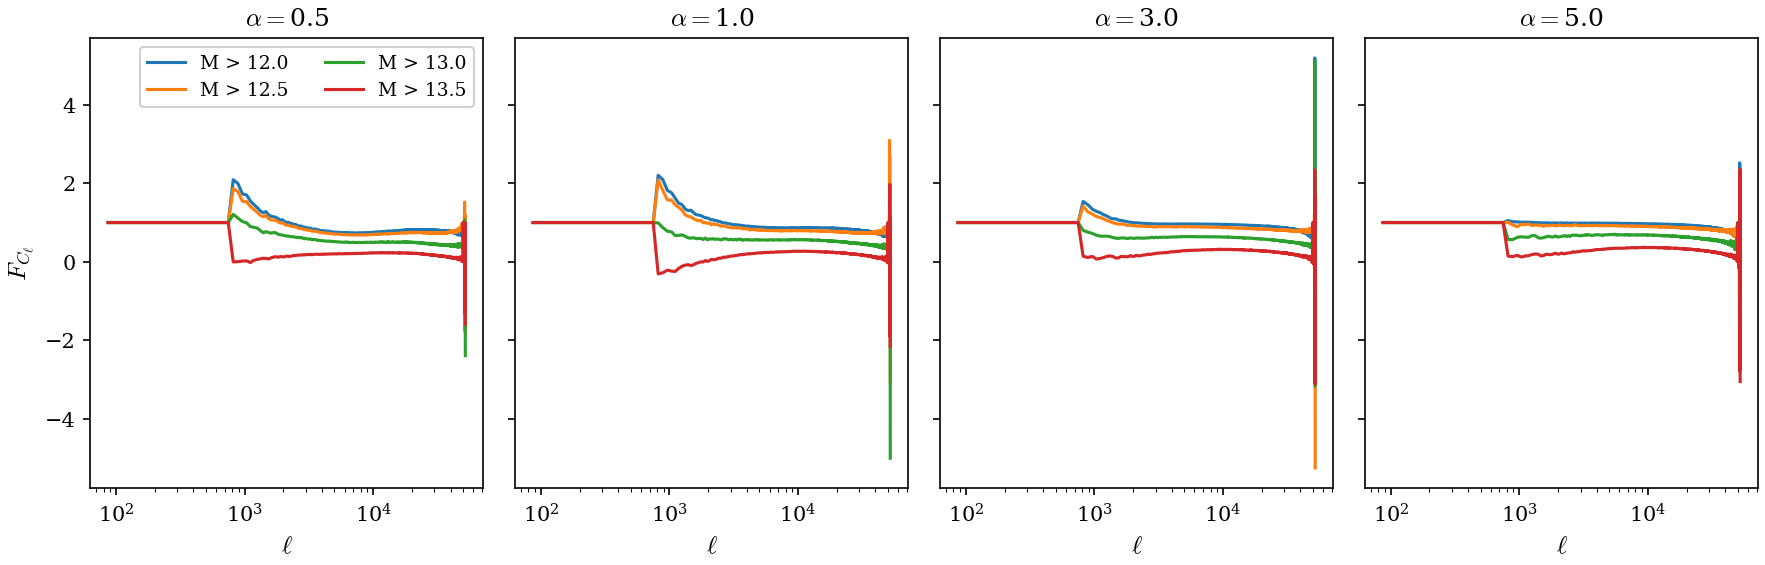

In [100]:
fig, axs = plt.subplots(ncols = 4, sharex=True, sharey=True, figsize=(12, 4))

for i in range(4):
    ax = axs[i]
    r_factor = r_factors[i]
    for j, model in enumerate(super_dict_cl.keys()):
        if 'R_' + str(r_factor) in model:
            temp = super_dict_cl[model]
            temp[bad_ell] = 1
            mass_thresh = np.round(np.log10(float(model.split('_')[3])), 2)
            alpha = float(model.split('_')[-1])
            ax.set_title(r'$\alpha=$' + str(alpha))
            ax.semilogx(ell, temp, label=f'M > {mass_thresh}')
# axs[0].set_ylim(-1, 2)
axs[0].legend(ncols=2)
for i in range(4):
    axs[i].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$F_{C_\ell}$')
plt.tight_layout()
plt.savefig('figures/F_cl.pdf')

In [101]:
import glob
Fs = sorted(glob.glob('./Fs/*'))
keys = np.load(Fs[0], allow_pickle=True)['F_peak'].item().keys()
super_dict_peaks = {k:[] for k in keys}
for F in Fs[:]:
    Fi = np.load(F, allow_pickle=True)
    for k, v in super_dict_peaks.items():
        try:
            v.append(Fi['F_peak'].item()[k])
        except:
            pass
super_dict_peaks = {k:np.mean(v, axis=0) for k, v in super_dict_peaks.items()}

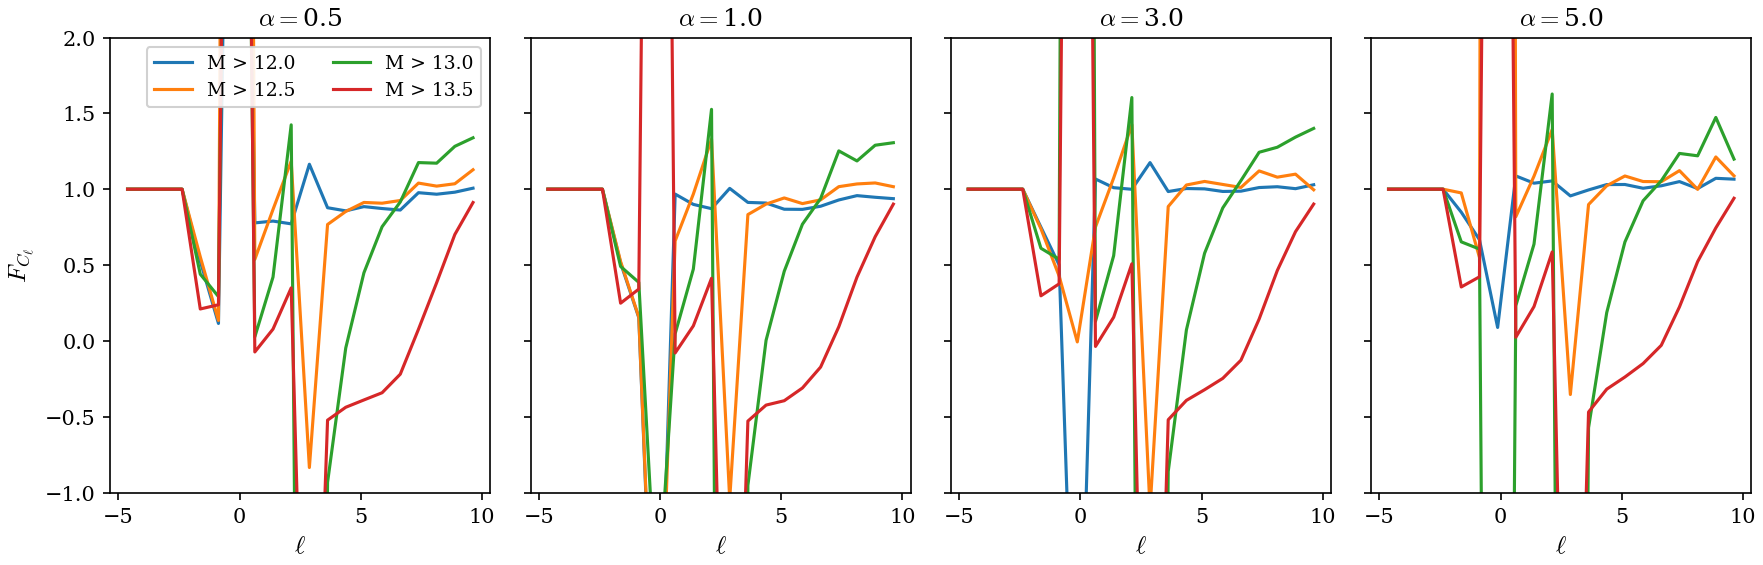

In [102]:
fig, axs = plt.subplots(ncols = 4, sharex=True, sharey=True, figsize=(12, 4))

for i in range(4):
    ax = axs[i]
    r_factor = r_factors[i]
    for j, model in enumerate(super_dict_peaks.keys()):
        if 'R_' + str(r_factor) in model:
            temp = super_dict_peaks[model]
            mass_thresh = np.round(np.log10(float(model.split('_')[3])), 2)
            alpha = float(model.split('_')[-1])
            ax.set_title(r'$\alpha=$' + str(alpha))
            ax.plot(SNR_MID, temp, label=f'M > {mass_thresh}')
axs[0].set_ylim(-1, 2)
axs[0].legend(ncols=2)
for i in range(4):
    axs[i].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$F_{C_\ell}$')
plt.tight_layout()
plt.savefig('figures/F_peak.pdf')

In [108]:
import glob
Fs = sorted(glob.glob('./Fs/*'))
keys = np.load(Fs[0], allow_pickle=True)['F_minima'].item().keys()
super_dict_minimas = {k:[] for k in keys}
for F in Fs[:]:
    Fi = np.load(F, allow_pickle=True)
    for k, v in super_dict_minimas.items():
        try:
            v.append(Fi['F_minima'].item()[k])
        except:
            pass
super_dict_minimas = {k:np.mean(v, axis=0) for k, v in super_dict_minimas.items()}

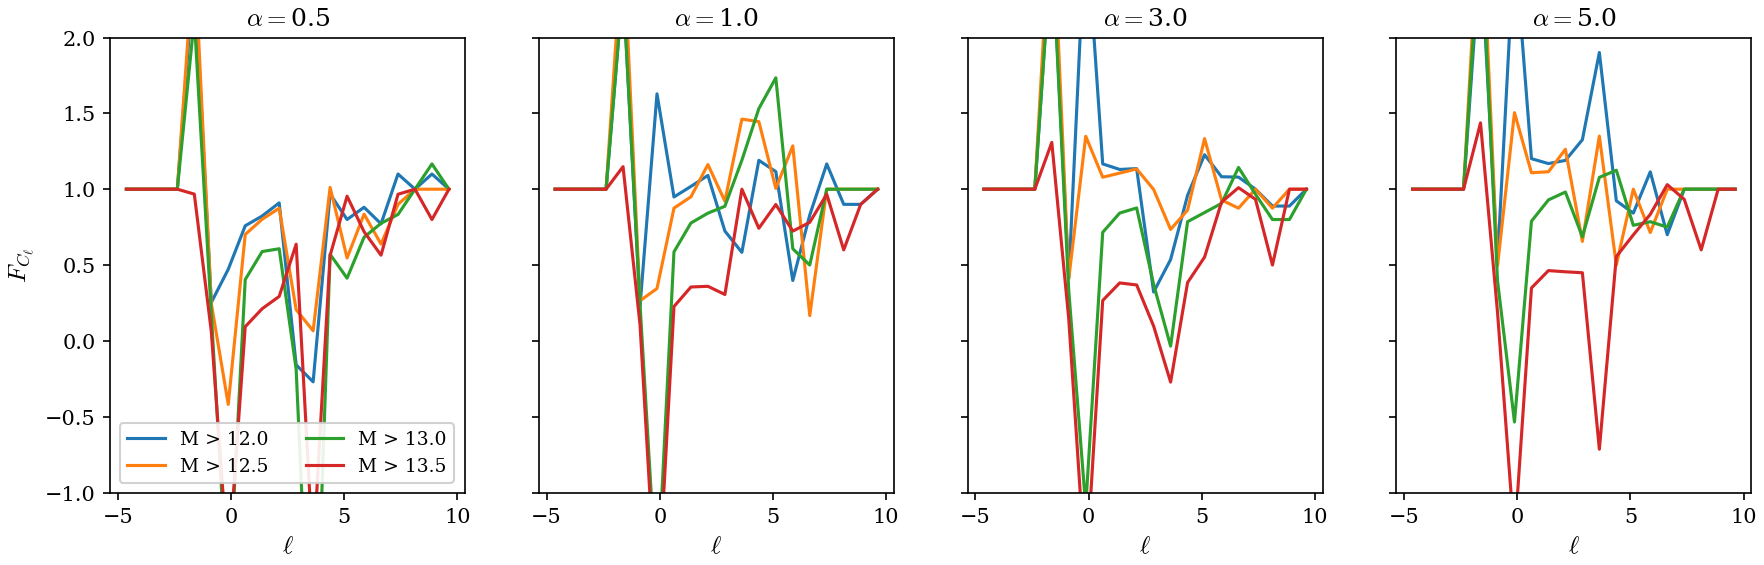

In [109]:
fig, axs = plt.subplots(ncols = 4, sharex=True, sharey=True, figsize=(12, 4))

for i in range(4):
    ax = axs[i]
    r_factor = r_factors[i]
    for j, model in enumerate(super_dict_minimas.keys()):
        if 'R_' + str(r_factor) in model:
            temp = super_dict_minimas[model]
            mass_thresh = np.round(np.log10(float(model.split('_')[3])), 2)
            alpha = float(model.split('_')[-1])
            ax.set_title(r'$\alpha=$' + str(alpha))
            ax.plot(SNR_MID, temp, label=f'M > {mass_thresh}')
axs[0].set_ylim(-1, 2)
axs[0].legend(ncols=2)
for i in range(4):
    axs[i].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$F_{C_\ell}$')
plt.tight_layout()
plt.savefig('figures/F_minimas.pdf')